/tmp/ipykernel_37/2614199276.py:20: DtypeWarning: Columns (4,5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/kaggle/input/consumer-complaint-database/rows.csv")


----- Logistic Regression -----
Accuracy: 0.9119
                  precision    recall  f1-score   support

Credit reporting       0.89      0.84      0.86      6318
 Debt collection       0.91      0.94      0.93     17342
   Consumer Loan       0.80      0.61      0.69      1895
        Mortgage       0.94      0.96      0.95     10597

        accuracy                           0.91     36152
       macro avg       0.88      0.84      0.86     36152
    weighted avg       0.91      0.91      0.91     36152



----- Multinomial Naive Bayes -----
Accuracy: 0.8721
                  precision    recall  f1-score   support

Credit reporting       0.81      0.77      0.79      6318
 Debt collection       0.89      0.90      0.90     17342
   Consumer Loan       0.78      0.42      0.54      1895
        Mortgage       0.89      0.96      0.92     10597

        accuracy                           0.87     36152
       macro avg       0.84      0.76      0.79     36152
    weighted avg     

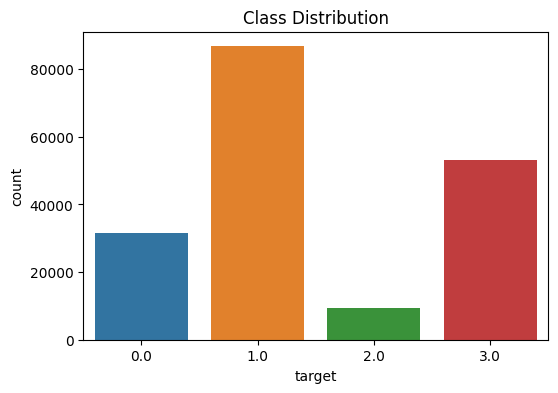

Best Model: Logistic Regression

Text: I am being charged unfairly by my credit card company
Predicted Category: Debt collection

Text: My mortgage payment is incorrect
Predicted Category: Mortgage

Text: Debt collector is harassing me
Predicted Category: Debt collection

Text: I need help with my consumer loan
Predicted Category: Mortgage



In [7]:
# -----------------------------
# Consumer Complaint Text Classification (CRT Version) with Model Comparison
# -----------------------------

# Import libraries
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Step 1: Load Dataset
# -----------------------------
df = pd.read_csv("/kaggle/input/consumer-complaint-database/rows.csv")
df.columns = df.columns.str.strip()

# Identify correct columns
product_col = "product" if "product" in df.columns else "Product"
text_col = "consumer_complaint_narrative" if "consumer_complaint_narrative" in df.columns else "Consumer complaint narrative"

# -----------------------------
# Step 2: Map products to target categories
# -----------------------------
category_map = {
    'Credit reporting': 0,
    'Credit reporting, credit repair services, or other': 0,
    'Debt collection': 1,
    'Consumer Loan': 2,
    'Mortgage': 3
}

df['target'] = df[product_col].map(category_map)
df = df.dropna(subset=['target', text_col])

# -----------------------------
# Step 3: Text Preprocessing
# -----------------------------
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text'] = df[text_col].apply(preprocess)

# -----------------------------
# Step 4: Train/Test Split
# -----------------------------
X = df['clean_text']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# -----------------------------
# Step 5: Feature Engineering (TF-IDF)
# -----------------------------
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# -----------------------------
# Step 6: Multi-Classification Models
# -----------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    acc = accuracy_score(y_test, y_pred)
    print(f"----- {name} -----")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=["Credit reporting", "Debt collection", "Consumer Loan", "Mortgage"]))
    results[name] = acc
    print("\n")

# Visualize class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=df)
plt.title("Class Distribution")
plt.show()

# -----------------------------
# Step 7: Prediction Example
# -----------------------------
sample_texts = [
    "I am being charged unfairly by my credit card company",
    "My mortgage payment is incorrect",
    "Debt collector is harassing me",
    "I need help with my consumer loan"
]

sample_clean = [preprocess(t) for t in sample_texts]
sample_vec = vectorizer.transform(sample_clean)

# Use the best model (highest accuracy) for prediction
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
preds = best_model.predict(sample_vec)

pred_map = {0: "Credit reporting", 1: "Debt collection", 2: "Consumer Loan", 3: "Mortgage"}
print(f"Best Model: {best_model_name}\n")
for text, p in zip(sample_texts, preds):
    print(f"Text: {text}\nPredicted Category: {pred_map[p]}\n")
